In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from helpers.utilities import *

In [2]:
from os import chdir
chdir('..')

The outputs will be saved to:

In [3]:
from helpers.paths import make_directories

make_directories({'clean': ['clinical']}, root='data')

In [4]:
from numpy import nan

In [5]:
import helpers.developer_mode

In [6]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(latex2exp)

Clinical data did not require a separate extraction step, thus I will clean the spreadsheet and explore the data in a single notebook (this one).

# Data Extraction

In [7]:
clinical_spreadsheets = read_excel('data/raw/PatientClinicalData.xlsx', sheet_name=None)

In [8]:
clinical_spreadsheets.keys()

odict_keys(['Clinical MetaData', 'Parameter Glossary'])

## Glossary

In [9]:
clinical_glossary = clinical_spreadsheets['Parameter Glossary']

In [10]:
full_table(clinical_glossary)

,PatientID,Randomisd study ID
0,Birthday,Date of birth
1,Sex,Gender at birth
2,PrevTB,Past history of TB?
3,PrevTBForm,What form of TB was it in the past? (Note: you can group any non-pulmonary as extrapulmonary for binary data)
4,PrevTBTreat,Did the patient receive TB treatment in the past?
5,TBMGrade,TBM grade (severity) at the time of admission; Grade 3 is the worst and Grade 1 is the least severe
6,HIVResult,Does the patient have HIV?
7,CD4,Number of CD4 T-cells per ml of blood
8,ARV,Is the patient currently on antiretroviral for HIV?
9,UnARV,"If not currently on ARV, has the patient ever taken ARV in the past?"


Perfect! Nice and computer readable format. Not much to see there.

The first raw was taken as a column name, I will mitigate it reloading the data with proper headers:

In [11]:
path = 'data/clean/clinical/glossary.csv'
clinical_glossary.to_csv(path, index=False)
clinical_glossary = read_csv(path, names=['variable', 'description'])

In [12]:
clinical_glossary.head()

,variable,description
0,PatientID,Randomisd study ID
1,Birthday,Date of birth
2,Sex,Gender at birth
3,PrevTB,Past history of TB?
4,PrevTBForm,What form of TB was it in the past? (Note: yo...


And save the clean copy:

In [13]:
clinical_glossary.to_csv(path)

## Clinical data

In [14]:
clinical_data = clinical_spreadsheets['Clinical MetaData']

In [15]:
clinical_data

,PatientID,Birthday,Sex,PrevTB,PrevTBForm,...,SteroidsStarted,SteroidDate,SteroidType,Death,DateDeath
0,001.TMD,1980-01-04,M,N,NaN,...,Y,2015-02-08,Prednisone,Alive,NaT
1,006.CM,1966-05-05,M,Y,Pulmonary,...,N,NaT,NaN,Alive,NaT
2,007.TMD,1984-02-28,F,N,NaN,...,Y,2015-02-16,Dexamethasone,Alive,NaT
3,011.TMR,1988-03-01,F,Y,"Pulmonary, TBM",...,N,NaT,NaN,Alive,NaT
4,012.BM,1961-01-09,M,N,NaN,...,N,NaT,NaN,Alive,NaT
...,...,...,...,...,...,...,...,...,...,...,...
90,247.CM,1977-11-10,M,Y,Pulmonary,...,N,NaT,NaN,Alive,NaT
91,248.TMD,1976-10-28,M,N,NaN,...,Y,2015-11-05,Prednisone,Alive,NaT
92,255.VM,1989-05-12,M,N,NaN,...,N,NaT,NaN,Alive,NaT
93,256.CM,1964-03-28,M,Y,NaN,...,Y,2015-11-10,Prednisone,Alive,NaT


In [16]:
from helpers.presentation import show_list, compare_sets

### Do we have description for each column?

In [17]:
compare_sets(clinical_data.columns, clinical_glossary.variable)

Okay, so there is a typo the glossary, I will fix that so to make data merges easier in the future:

In [18]:
clinical_glossary.variable = clinical_glossary.variable.replace({'OnTBTReat': 'OnTBTreat'})
clinical_glossary.to_csv(path, index=False)

Should work now:

In [19]:
assert set(clinical_data.columns) == set(clinical_glossary.variable)

# Data exploration and reformatting

I do not see an atomic column with condition; for simplicity I will create it now:

In [20]:
clinical_data['condition'] = clinical_data.PatientID.str.split('.').str[1]

In [21]:
clinical_data['condition'].value_counts()

CM     27
HC     25
TMD    18
TMR     9
VM      8
TMS     6
BM      2
Name: condition, dtype: int64

## Getting to know the variables

There are only 37 variables so I will explore each of these, one-by-one.

The descriptions from glossary will come in handy:

In [22]:
glossary = clinical_glossary.set_index('variable').description

### 1. PatientID

We should have data for all patients:

In [23]:
samples_list = read_csv('data/clean/samples_list.csv')

In [24]:
compare_sets(samples_list.sample_id, clinical_data.PatientID)

Great!

In [25]:
len(samples_list.sample_id)

95

### 2. Birthday

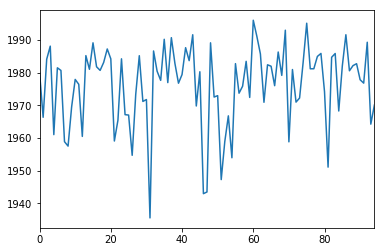

In [26]:
clinical_data.Birthday.plot();

In [27]:
clinical_data.Birthday.describe()

count                      95
unique                     95
top       1971-03-16 00:00:00
freq                        1
first     1935-06-25 00:00:00
last      1996-02-10 00:00:00
Name: Birthday, dtype: object

The value ranges are plausible (as the has data from ~2015, the oldest participant had about 80 years), no suspicious duplicates.

### 3. History of TB

PrevTB is expected to be a binary column:

In [28]:
set(clinical_data.PrevTB)

{'N', 'Unknown', 'Y', nan}

In [29]:
clinical_data[~clinical_data.PrevTB.isin(['N', 'Y'])]

,PatientID,Birthday,Sex,PrevTB,PrevTBForm,...,SteroidDate,SteroidType,Death,DateDeath,condition
6,015.CM,1980-09-15,F,NaN,NaN,...,NaT,NaN,Death,2015-05-04,CM
21,049.TMS,1959-01-25,M,Unknown,NaN,...,2015-03-18,Dexamethasone,Death,2015-03-24,TMS
31,080.HC,1935-06-25,F,Unknown,NaN,...,NaT,NaN,Alive,NaT,HC


I assume that the 'Unknown' and missing values convey the same information of the history of TB not being known.

In [30]:
clinical_data.PrevTB = clinical_data.PrevTB.replace({'N': False, 'Y': True, 'Unknown': nan})

In [31]:
counts = clinical_data.PrevTB.fillna('Unknown').value_counts()
counts.to_frame()

,PrevTB
False,52
True,40
Unknown,3


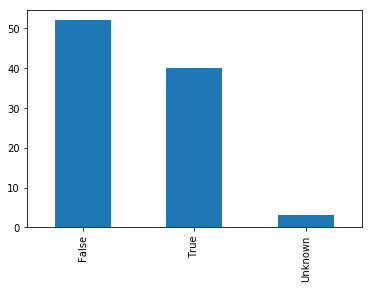

In [32]:
counts.plot(kind='bar');

In [33]:
patients_with_history_of_tb = clinical_data[clinical_data.PrevTB == True].PatientID

### 4. Form of previous TB

In [34]:
glossary['PrevTBForm']

'What form of TB was it in the past?  (Note: you can group any non-pulmonary as extrapulmonary for binary data)'

In [35]:
clinical_data['PrevTBForm'].value_counts().to_frame()

,PrevTBForm
Pulmonary,35
"Pulmonary, Pleural",1
"Pulmonary, TBM",1
"Pulmonary, Meningeal",1
Meningeal,1


This column does not satisfy the first normal form - I will add binary columns (as suggested in the description):

In [36]:
clinical_data['was_previous_tb_pulmonary'] = clinical_data.apply(lambda patient:
    # ignore patients with no history of TB (set the value to NaN):
    nan if not (patient.PrevTB == True) else
    'Pulmonary' in str(patient.PrevTBForm)
, axis=1)

**To consult:** does pleural count as pulmonary or as extrapulmonary?

In [37]:
clinical_data['was_previous_tb_extrapulmonary'] = clinical_data.apply(lambda patient:
    # ignore patients with no history of TB (set the value to NaN)
    nan if not (patient.PrevTB == True) else
    (
        'TBM' in str(patient.PrevTBForm)
        or
        'Meningeal' in str(patient.PrevTBForm)
    )
, axis=1)

I will not create a separate column for *meningeal* as in any case it would be too strongly correlated with *extrapulmonary* - I do not think that the single additional observation (potential inclusion of *pleural* patient in the *extrapulmonary* cohort) would lead to a big change - and if so, it would be an outlier anyway.

In [38]:
clinical_data[['PrevTB', 'PrevTBForm', 'was_previous_tb_pulmonary', 'was_previous_tb_extrapulmonary']].head(n=8)

,PrevTB,PrevTBForm,was_previous_tb_pulmonary,was_previous_tb_extrapulmonary
0,False,NaN,NaN,NaN
1,True,Pulmonary,True,False
2,False,NaN,NaN,NaN
3,True,"Pulmonary, TBM",True,True
4,False,NaN,NaN,NaN
5,False,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,True,Pulmonary,True,False


### Sanity check

If patient has a form of previous TB given, they should be marked as having history of TB:

In [39]:
patients_with_previous_tb_form_data = clinical_data[~clinical_data.PrevTBForm.isnull()].PatientID
assert not set(patients_with_previous_tb_form_data) - set(patients_with_history_of_tb)

And it is indeed the case. How many patients have known history but no subtype given?

In [40]:
compare_sets(patients_with_history_of_tb, patients_with_previous_tb_form_data)

Just one - that's very good!

### 4. Treatment for the previous TB

In [41]:
glossary['PrevTBTreat']

'Did the patient receive TB treatment in the past?'

In [42]:
clinical_data['PrevTBTreat'].value_counts()

Y          40
Unknown     2
N           1
Name: PrevTBTreat, dtype: int64

I will create an additional, binary column for the previous treatment, with a different encoding for missing values:

In [43]:
clinical_data['previous_tb_treatment'] = clinical_data.apply(lambda patient:
    nan if not (patient.PrevTB == True) else
    (
        nan if patient.PrevTBTreat == 'Unknown' else
        patient.PrevTBTreat == 'Y'
    )
, axis=1)

In [44]:
subset = clinical_data[['PatientID', 'PrevTB', 'PrevTBTreat', 'previous_tb_treatment']]
subset.head(n=2)

,PatientID,PrevTB,PrevTBTreat,previous_tb_treatment
0,001.TMD,False,NaN,NaN
1,006.CM,True,Y,True


In [45]:
subset.tail(40).head(8)

,PatientID,PrevTB,PrevTBTreat,previous_tb_treatment
55,138.HC,False,NaN,NaN
56,145.CM,True,Y,True
57,146.CM,True,Y,True
58,148.HC,False,N,NaN
59,149.TMD,False,NaN,NaN
60,151.TMD,False,NaN,NaN
61,153.CM,True,Y,True
62,154.VM,True,Y,True


An example of the advantage of the new column is that `148.HC` (58th row) has `NaN` assigned because this patient has no history of TB. The original, `PrevTBTreat` column has 'N' value for this patient. This may be slightly suspicious, given that some other patients (e.g. `149.TMD`/59th row) who also have no history of TB have `NaN` in the original column.

### Sanity check

In [46]:
patients_with_previous_tb_treatment = clinical_data[clinical_data.PrevTBTreat == 'Y'].PatientID
assert not set(patients_with_previous_tb_treatment) - set(patients_with_history_of_tb)

### 5. Grade of TBM

In [47]:
glossary['TBMGrade']

'TBM grade (severity) at the time of admission; Grade 3 is the worst and Grade 1 is the least severe'

In [48]:
clinical_data['TBMGrade'].value_counts()

1    62
2    31
3     2
Name: TBMGrade, dtype: int64

Already in numeric format, that's great.

**Note:** only two patients with grade three!

### 6. HIV Result

In [49]:
glossary['HIVResult']

'Does the patient have HIV?'

In [50]:
clinical_data['HIVResult'].value_counts()

Positive    79
Negative    16
Name: HIVResult, dtype: int64

### 7. CD4

In [51]:
glossary['CD4']

'Number of CD4 T-cells per ml of blood'

Distribution is skewed towards zero:

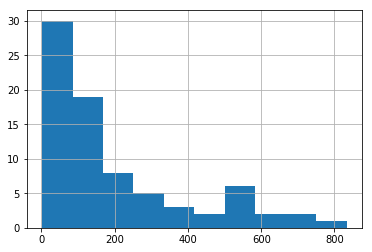

In [52]:
clinical_data['CD4'].hist();

In [53]:
clinical_data['CD4'].describe()

count     78.000000
mean     196.076923
std      202.018886
min        2.000000
25%       51.250000
50%      114.000000
75%      273.250000
max      833.000000
Name: CD4, dtype: float64

And there are data for 78/95 patients.

A quick search tells me that CD4 count is related to HIV/AIDS. A [US governmental site](https://www.hiv.va.gov/patient/diagnosis/labs-CD4-count.asp) tells me that 200 is a threshold for AIDS diagnosis but they do not give units; I am going to find a more accurate and reliable source and also read [PMC3729334](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3729334/) to understand the context a bit better (it goes to the bottom of my reading list, but if there are better/more relevant articles please let me know).

### 8. Is patient on antiretroviral drug(s)?

In [54]:
glossary['ARV']

'Is the patient currently on antiretroviral for HIV?'

In [55]:
clinical_data['ARV'].value_counts()

N    42
Y    37
Name: ARV, dtype: int64

No need to reformat to another binary format as there are no "Unknown" values.

Data 79 patients, similar to the 78 above.
Is there a pattern in the missing data - e.g. are these only missing in healthy controls?

In [56]:
show_list(clinical_data[clinical_data['ARV'].isnull()].PatientID)

No, it is not the case.

### 9. History of treatment with antiretroviral drugs?

In [57]:
glossary['UnARV']

'If not currently on ARV, has the patient ever taken ARV in the past?'

In [58]:
clinical_data['UnARV'].value_counts()

ARV-naive          32
PreviousHistory     9
Name: UnARV, dtype: int64

**What does the "ARV-naive" mean?**

Very little data - for only 41 patients. Which ones?

In [59]:
patients_with_avr_data = clinical_data[~clinical_data['UnARV'].isnull()]

In [60]:
patients_with_avr_data.condition.value_counts()

CM     16
TMD     9
HC      7
TMR     5
TMS     3
VM      1
Name: condition, dtype: int64

In [61]:
patients_with_avr_data.HIVResult.value_counts()

Positive    41
Name: HIVResult, dtype: int64

**Does lack of data mean "No" or "Unknown"?**

### 10. Headache

In [62]:
clinical_data['Headache'].value_counts()

Y          73
N          19
Unknown     3
Name: Headache, dtype: int64

Reformatting to binary format with NaN for unknown:

In [63]:
clinical_data['Headache'] = clinical_data['Headache'].replace({
    'Y': True,
    'N': False,
    'Unknown': nan
})

### 11. Duration of headache

In [64]:
glossary['HeadacheD']

'Duration of headache (days)'

TBD

## Patient-wise exploration

are there any patients for whom there is too little data in general?

TBD

## Simple correlations

TBD